# Citibike ML
In this example we use the [Citibike dataset](https://ride.citibikenyc.com/system-data). Citibike is a bicycle sharing system in New York City. Everyday users choose from 20,000 bicycles at 1300 stations around New York City.

To ensure customer satisfaction Citibike needs to predict how many bicycles will be needed at each station. Maintenance teams from Citibike will check each station and repair or replace bicycles. Additionally, the team will relocate bicycles between stations based on predicted demand. The business needs to be able to run reports of how many bicycles will be needed at a given station on a given day.

## Data Exploration and Modeling

Now we're to the fun part - the Data Science. Now that the data engineers have cleaned and loaded the data to the `trips` table, we can begin our model development. For this, we will leverage Snowpark to do the **feature preparation and exploratory analysis**.   This dataset is initially ~100 million rows and is likely too large to fit into memory on our local machine or even a reasonable sized single VM in the cloud. The Snowpark Python client-side Dataframe API 
allows us to push-down most of the computation for preparation and feature engineering to Snowpark. For security and goverance reasons we can read data into memory for model training and inference but no intermediate data products can be stored outside of Snowflake.  

For this demo flow we will assume that the organization has the following **policies and processes** :   
-**Dev Tools**: The data scientist can develop in their tool of choice (ie. DataRobot, Dataiku, H2o, Sagemaker, AzureML, etc.).  Snowpark Python makes it possible to use any environment with a python kernel.  For the sake of a demo we will use Jupyter.  
-**Data Governance**: To preserve customer privacy no data can be stored locally.  The ingest system may store data temporarily but it must be assumed that, in production, the ingest system will not preserve intermediate data products between runs. Snowpark Python allows the user to push-down all operations to Snowflake and bring the code to the data.   
-**Automation**: Although the data scientist may use any IDE or notebooks for development purposes the final product must be python code at the end of the work stream.  Well-documented, modularized code is necessary for good ML operations and to interface with the company's CI/CD and orchestration tools.  
-**Compliance**: Any ML models must be traceable back to the original data set used for training.  The business needs to be able to easily remove specific user data from training datasets and retrain models. 

Input: Data in `trips` table.   
Output: Feature engineering logic.  Train function.  Predict function.

For this demo we will rewind in time and assume that it is March 1, 2020.  With the bulk ingest we have 94M records from 2013 to March 2020.

In [1]:
#today = '2020-03-01'

In [2]:
#!pip install -q matplotlib seaborn pytorch-tabnet statsmodels

### 1. Load the Credentials


In [3]:
from dags.snowpark_connection import snowpark_connect
session, state_dict = snowpark_connect()

### 2. Exploratory Data Analysis

In [4]:
import snowflake.snowpark as snp
from snowflake.snowpark import functions as F
from snowflake.snowpark import types as T

import pandas as pd
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error

#import logging
#logging.basicConfig(level=logging.WARN)
#logging.getLogger().setLevel(logging.DEBUG)

In [5]:
trips_table_name = state_dict['trips_table_name']

In [6]:
session.table(trips_table_name).select(F.min('STARTTIME'), F.max('STARTTIME')).show()
session.table(trips_table_name).count()

-----------------------------------------------------
|"MIN(""STARTTIME"")"  |"MAX(""STARTTIME"")"        |
-----------------------------------------------------
|2013-06-01 00:00:01   |2020-02-29 23:59:35.607000  |
-----------------------------------------------------



94278419

This is too large to fit in memory on my local system.  Lets summarize trips to daily resolution and inspect the first ten rows

In [7]:
snowdf = session.table(trips_table_name)
snowdf.with_column('DATE', F.to_date('STARTTIME')).group_by('DATE').count().sort('DATE').show(10)

------------------------
|"DATE"      |"COUNT"  |
------------------------
|2013-06-01  |8721     |
|2013-06-02  |15971    |
|2013-06-03  |7598     |
|2013-06-04  |15782    |
|2013-06-05  |15690    |
|2013-06-06  |12420    |
|2013-06-07  |1226     |
|2013-06-08  |18007    |
|2013-06-09  |21034    |
|2013-06-10  |3897     |
------------------------



Once we aggregate the data at the day level we have a small enough dataset to fit in memory.  But we may want to provide a more granular time series (ie. hour or minute-level) or perhaps our data will grow considerably over time.  In either case we can't rely on in-memory computation and will want to push-down as much computation as possible to Snowflake.  
  
For exploration purposes we can see a good daily and annual seasonality in the historical data.

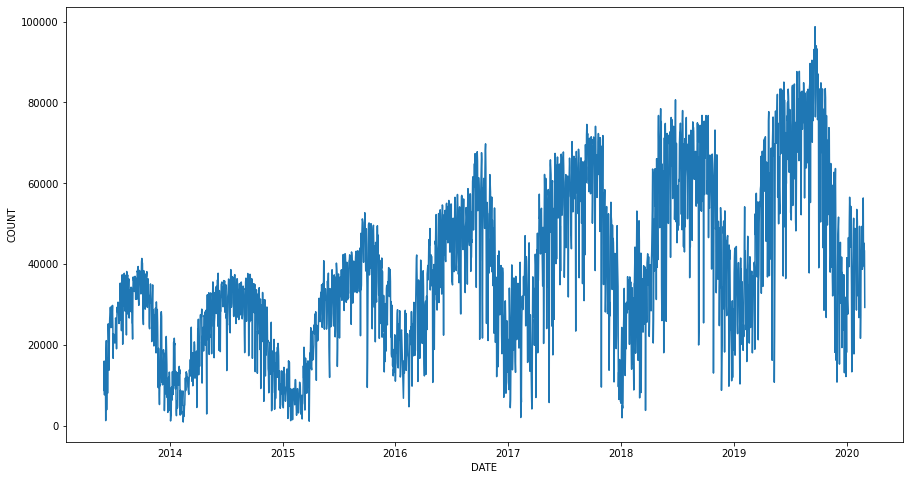

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df = snowdf.with_column("date", F.to_date("STARTTIME")).group_by("date").count().sort("date").to_pandas()
df.head()

plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='DATE', y='COUNT', data=df)

We may not be able to get a good model that can predict across ALL stations.  Lets start with just the busiest station(s).

In [9]:
snowdf.filter(F.col('START_STATION_ID').is_not_null()) \
      .group_by('START_STATION_ID') \
      .count() \
      .sort('COUNT', ascending=False).show()

--------------------------------
|"START_STATION_ID"  |"COUNT"  |
--------------------------------
|519                 |891075   |
|497                 |677978   |
|435                 |641626   |
|402                 |605584   |
|426                 |598851   |
|285                 |571331   |
|293                 |549381   |
|490                 |536132   |
|477                 |508478   |
|459                 |508018   |
--------------------------------



Initially we will build with the busiest station "Central Park S & 6 Ave" which is STATION_ID=519.  Later we will see how Snowpark Python allows us to tap into the powerful horizontally, scalable compute engine to parallelize this across all stations.

In [10]:
top_stations = snowdf.filter(F.col('START_STATION_ID').is_not_null()) \
                                                   .groupBy('START_STATION_ID') \
                                                   .count() \
                                                   .sort('COUNT', ascending=False) \
                                                   .toPandas()['START_STATION_ID'].values.tolist()
top_stations[0:10]

['519', '497', '435', '402', '426', '285', '293', '490', '477', '459']

In [11]:
df = snowdf.filter(F.col('START_STATION_ID') == top_stations[0]) \
      .withColumn('DATE', 
                  F.call_builtin('DATE_TRUNC', ('DAY', F.col('STARTTIME')))) \
      .groupBy('DATE') \
      .count() \
      .sort('DATE').toPandas()

df.head()

,DATE,COUNT
0,2013-06-01,33
1,2013-06-02,46
2,2013-06-03,41
3,2013-06-04,72
4,2013-06-05,114


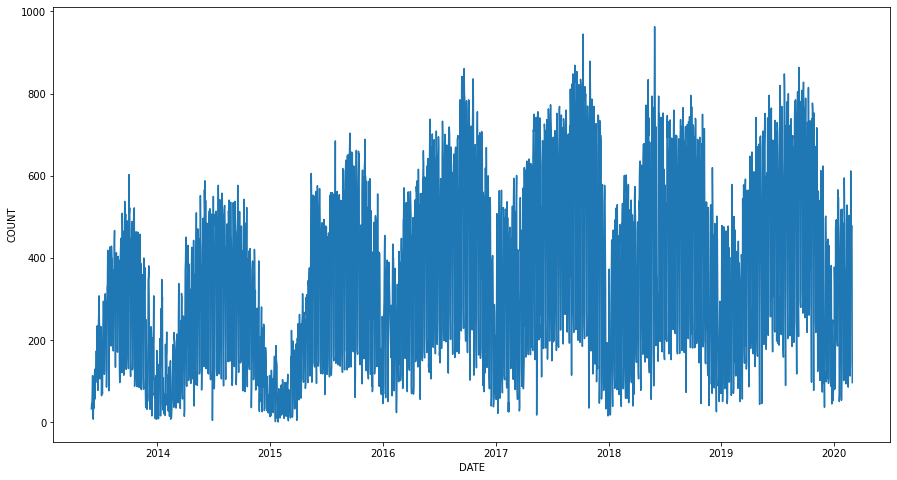

In [12]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='DATE', y='COUNT', data=df)

We can see what looks like daily, weekly and annual periodicity as well as a slight upward trend over years. To start building the features for a regression model we might start with lag features. We can use autocorrelation to confirm our initial guess.

In [13]:
df

,DATE,COUNT
0,2013-06-01,33
1,2013-06-02,46
2,2013-06-03,41
3,2013-06-04,72
4,2013-06-05,114
...,...,...
2448,2020-02-25,372
2449,2020-02-26,453
2450,2020-02-27,479
2451,2020-02-28,425


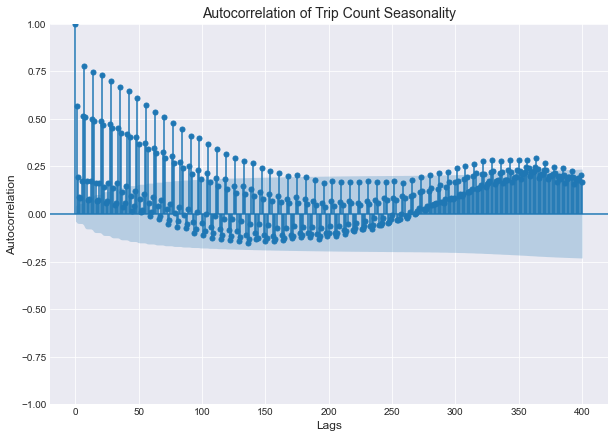

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rc("figure", figsize=(10, 7))
plot_acf(df['COUNT'], lags=400)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of Trip Count Seasonality', fontsize=14)
plt.show()

We can definitely see the strong annual seasonality.

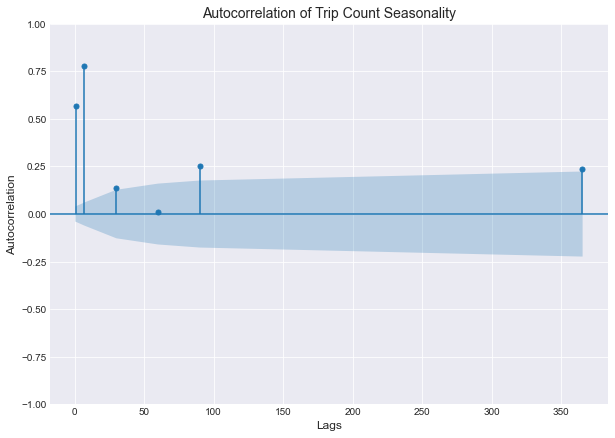

In [15]:
plt.rc("figure", figsize=(10, 7))
plot_acf(df['COUNT'], lags=[1, 7, 30, 60, 90, 365])
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of Trip Count Seasonality', fontsize=14)
plt.show()

Snowpark has many [functions](https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/_autosummary/snowflake.snowpark.functions.html) for things like transformation, statistical analysis, etc. We will use the `lag()` window function to generate lag features.  
  
In addition to the rich set of Snowpark functions, users can also tap into the wealth of [Snowflake built-in functions](https://docs.snowflake.com/en/sql-reference/functions-all.html) using the `call_builtin()` function. 

Here we will generate our features in a function which we may need to add to over time.  In the end the function provides a running list of transformations to build our feature pipeline for inference and training.

In [18]:
def generate_features(snowdf):
    
    snowdf = snowdf.select(F.to_date(F.col('STARTTIME')).alias('DATE'),
                           F.col('START_STATION_ID').alias('STATION_ID'))\
                   .group_by(F.col('STATION_ID'), F.col('DATE'))\
                   .count()
    
    #Impute missing values for lag columns using mean of the previous period.
    mean_1 = round(snowdf.sort('DATE').limit(1).select(F.mean('COUNT')).collect()[0][0])
    mean_7 = round(snowdf.sort('DATE').limit(7).select(F.mean('COUNT')).collect()[0][0])
    mean_90 = round(snowdf.sort('DATE').limit(90).select(F.mean('COUNT')).collect()[0][0])
    mean_365 = round(snowdf.sort('DATE').limit(365).select(F.mean('COUNT')).collect()[0][0])

    date_win = snp.Window.order_by('DATE')

    snowdf = snowdf.with_column('LAG_1', F.lag('COUNT', offset=1, default_value=mean_1) \
                                         .over(date_win)) \
                   .with_column('LAG_7', F.lag('COUNT', offset=7, default_value=mean_7) \
                                         .over(date_win)) \
                   .with_column('LAG_90', F.lag('COUNT', offset=90, default_value=mean_90) \
                                         .over(date_win)) \
                   .with_column('LAG_365', F.lag('COUNT', offset=365, default_value=mean_365) \
                                         .over(date_win)) \
                   .na.drop()
    return snowdf

In [19]:
train_snowdf = generate_features(snowdf.filter(F.col('START_STATION_ID') == top_stations[0]))
train_snowdf.show()

----------------------------------------------------------------------------------
|"STATION_ID"  |"DATE"      |"COUNT"  |"LAG_1"  |"LAG_7"  |"LAG_90"  |"LAG_365"  |
----------------------------------------------------------------------------------
|519           |2013-06-01  |33       |33       |55       |227       |229        |
|519           |2013-06-02  |46       |33       |55       |227       |229        |
|519           |2013-06-03  |41       |46       |55       |227       |229        |
|519           |2013-06-04  |72       |41       |55       |227       |229        |
|519           |2013-06-05  |114      |72       |55       |227       |229        |
|519           |2013-06-06  |68       |114      |55       |227       |229        |
|519           |2013-06-07  |8        |68       |55       |227       |229        |
|519           |2013-06-08  |47       |8        |33       |227       |229        |
|519           |2013-06-09  |69       |47       |46       |227       |229        |
|519

### Baseline
Lets build a baseline with ARIMA since we already have statsmodels

In [28]:
import statsmodels.api as sm


### 3. Model Development and Experimentation
We will use [pytorch_tabnet](https://github.com/dreamquark-ai/tabnet) from the 2019 [tabnet paper](https://arxiv.org/pdf/1908.07442.pdf) by Arik, S. O. and Pfister, T.  Tabnet is a powerful deep learning framework for attentive, interpretable learning on tabular data.  Rather than substantial focus on hyper-parameter optimization  we will start with an initial set of hyper-parameters and focus on iterating over input features for now.  
  
Rather than a random split of training/validation data we will split the training dataset using a `cutpoint`.  For example we will save the final 365 days of the dataset as validation and train with the remaining data.

In [15]:
def train(X, y, cutpoint=365, cat_idxs=[], cat_dims=[]):    
    X_valid = X[-cutpoint:]
    y_valid = y[-cutpoint:]
    X_train = X[:-cutpoint]
    y_train = y[:-cutpoint]

    from pytorch_tabnet.tab_model import TabNetRegressor
    import pandas as pd

    max_epochs = 100
    
    batch_df = pd.DataFrame(range(2,65,2), columns=['batch_size'])
    batch_df['batch_remainder'] = len(X_train)%batch_df['batch_size']
    optimal_batch_size=int(batch_df['batch_size'].where(batch_df['batch_remainder']==batch_df['batch_remainder'].min()).max())
    
    print('Selected batch size '+str(optimal_batch_size)+' for input data size: '+str(len(X_train)))
    
    regression_model = TabNetRegressor(cat_idxs=cat_idxs, cat_dims=cat_dims)

    regression_model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        max_epochs=max_epochs,
        patience=10,
        batch_size=optimal_batch_size, 
        virtual_batch_size=optimal_batch_size/2,
        num_workers=0,
        drop_last=True)
    
    return regression_model

def predict(model, X):
    y_hat = model.predict(X).reshape(-1)
    return y_hat
    
def plot(df, x_lab:str, y_true_lab:str, y_pred_lab:str):
    plt.figure(figsize=(15, 8))
    df = pd.melt(df, id_vars=[x_lab], value_vars=[y_true_lab, y_pred_lab])
    ax = sns.lineplot(x=x_lab, y='value', hue='variable', data=df)

We will create a pandas dataframe using toPandas() which will generate the features as a pyarrow dataset and efficiently read them into memory in pandas locally.  
  
Let's train our first model to get a baseline. 

In [16]:
def train_predict(df, cat_idxs=[], cat_dims=[]):
    target = ['COUNT']
    feature_columns = [feature.replace('\"', '') for feature in df.columns]
    feature_columns.remove(target[0])
    feature_columns.remove('DATE')
    feature_columns.remove('STATION_ID')

    model = train(df[feature_columns].astype(float).values, 
                  df[target].values,
                  cat_idxs=cat_idxs, 
                  cat_dims=cat_dims)
    df['Y_PRED'] = predict(model, df[feature_columns].astype(float).values).astype('int')

    explain_df = pd.DataFrame(model.explain(df[feature_columns].astype(float).values)[0], 
                          columns = feature_columns).add_prefix('EXPL_').round(2)
    df = pd.concat([df.set_index('DATE').reset_index(), explain_df], axis=1)
    
    MSE = mean_squared_error(y_pred=df['Y_PRED'], y_true=df[target])
    display("Error for training dataset is: "+str(MSE))
    
    return df, model, feature_columns

In [17]:
df = train_snowdf.sort('DATE', ascending=True).to_pandas()
df, model, feature_columns = train_predict(df)

Selected batch size 58 for input data size: 2088
Device used : cpu
epoch 0  | loss: 165899.23546| val_0_mse: 118136.69459|  0:00:00s
epoch 1  | loss: 129446.45985| val_0_mse: 83329.83431|  0:00:01s
epoch 2  | loss: 74875.11936| val_0_mse: 28469.45016|  0:00:02s
epoch 3  | loss: 31196.74398| val_0_mse: 29692.14535|  0:00:03s
epoch 4  | loss: 19927.08138| val_0_mse: 43717.19234|  0:00:04s
epoch 5  | loss: 18923.55244| val_0_mse: 26038.79811|  0:00:05s
epoch 6  | loss: 18140.37135| val_0_mse: 24176.14534|  0:00:06s
epoch 7  | loss: 18394.47165| val_0_mse: 23919.128|  0:00:07s
epoch 8  | loss: 17424.48842| val_0_mse: 23753.94594|  0:00:08s
epoch 9  | loss: 18321.42135| val_0_mse: 22693.25254|  0:00:09s
epoch 10 | loss: 18276.47453| val_0_mse: 24116.70778|  0:00:10s
epoch 11 | loss: 17612.7379| val_0_mse: 23900.32286|  0:00:11s
epoch 12 | loss: 18214.77431| val_0_mse: 22943.52863|  0:00:12s
epoch 13 | loss: 18122.39434| val_0_mse: 22420.62382|  0:00:12s
epoch 14 | loss: 18244.36475| val_0_m

'Error for training dataset is: 17396.612719119446'

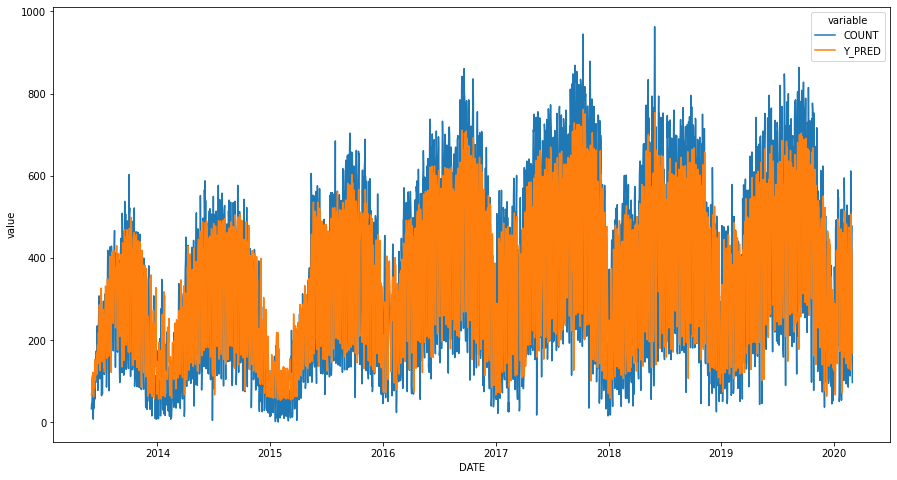

In [18]:
plot(df, 'DATE', 'COUNT', 'Y_PRED')

#### What if we add US holidays as a feature?
Pandas has great support for holiday lists.  We can generate a pandas dataframe and then upload it as a table to create a new feature.

In [19]:
def generate_holiday_df(session, start_date, end_date):
    from snowflake.snowpark import functions as F 
    import pandas as pd
    from pandas.tseries.holiday import USFederalHolidayCalendar

    cal = USFederalHolidayCalendar()
    holiday_list = pd.DataFrame(cal.holidays(start=start_date, end=end_date), columns=['DATE'], dtype=str)
    holiday_df = session.create_dataframe(holiday_list) \
                        .toDF(holiday_list.columns[0]) \
                        .with_column("HOLIDAY", F.lit(1))
    return holiday_df
    
start_date, end_date = train_snowdf.select(F.min('DATE'), F.max('DATE')).collect()[0][0:2]

holiday_df = generate_holiday_df(session, start_date=start_date, end_date=end_date)
holiday_df.show(3)

---------------------------------------------
|"DATE"                         |"HOLIDAY"  |
---------------------------------------------
|2013-07-04T00:00:00.000000000  |1          |
|2013-09-02T00:00:00.000000000  |1          |
|2013-10-14T00:00:00.000000000  |1          |
---------------------------------------------



Here we create an in-memory instance of the holiday dataframe.  In production we probably want to materialize this feature as a table or view.  We'll see later how that is easy to do but for now we have a function to generate it and join it to our training dataframe as a one-hot feature.

Every time we join there is a possibility of losing data from our feature set if the join column doesn't cover the same dates.  So its good to check.

In [20]:
train_snowdf = train_snowdf.join(holiday_df, 'DATE', join_type='left') \
                           .na.fill({'HOLIDAY':0}) \
                           .sort('DATE', ascending=True)
train_snowdf.show()

----------------------------------------------------------------------------------------------
|"DATE"      |"STATION_ID"  |"COUNT"  |"LAG_1"  |"LAG_7"  |"LAG_30"  |"LAG_365"  |"HOLIDAY"  |
----------------------------------------------------------------------------------------------
|2013-06-01  |519           |33       |33       |55       |129       |229        |0          |
|2013-06-02  |519           |46       |33       |55       |129       |229        |0          |
|2013-06-03  |519           |41       |46       |55       |129       |229        |0          |
|2013-06-04  |519           |72       |41       |55       |129       |229        |0          |
|2013-06-05  |519           |114      |72       |55       |129       |229        |0          |
|2013-06-06  |519           |68       |114      |55       |129       |229        |0          |
|2013-06-07  |519           |8        |68       |55       |129       |229        |0          |
|2013-06-08  |519           |47       |8        |3

Now when we train we need to specify this new holiday feature as a categorical feature.  Its already encoded (by definition) so nothing to add there.

In [21]:
df = train_snowdf.sort('DATE', ascending=True).to_pandas()
df, model, feature_columns = train_predict(df, cat_idxs=[-1], cat_dims=[2])

Selected batch size 58 for input data size: 2088
Device used : cpu
epoch 0  | loss: 163557.58398| val_0_mse: 91971.3332|  0:00:00s
epoch 1  | loss: 125779.06684| val_0_mse: 83784.99669|  0:00:01s
epoch 2  | loss: 71575.88921| val_0_mse: 30523.53722|  0:00:02s
epoch 3  | loss: 30773.86879| val_0_mse: 35039.49629|  0:00:03s
epoch 4  | loss: 18916.85729| val_0_mse: 26717.23994|  0:00:04s
epoch 5  | loss: 18344.74826| val_0_mse: 23408.76341|  0:00:05s
epoch 6  | loss: 17423.36787| val_0_mse: 23979.56652|  0:00:06s
epoch 7  | loss: 17100.39676| val_0_mse: 27959.73566|  0:00:07s
epoch 8  | loss: 16968.82907| val_0_mse: 23641.42908|  0:00:08s
epoch 9  | loss: 17542.61692| val_0_mse: 21918.63744|  0:00:09s
epoch 10 | loss: 17137.90923| val_0_mse: 24339.07868|  0:00:10s
epoch 11 | loss: 17393.78752| val_0_mse: 21823.57229|  0:00:10s
epoch 12 | loss: 16758.58694| val_0_mse: 21493.7662|  0:00:11s
epoch 13 | loss: 17064.50757| val_0_mse: 22560.15984|  0:00:12s
epoch 14 | loss: 17317.36301| val_0_m

'Error for training dataset is: 14584.352629433348'

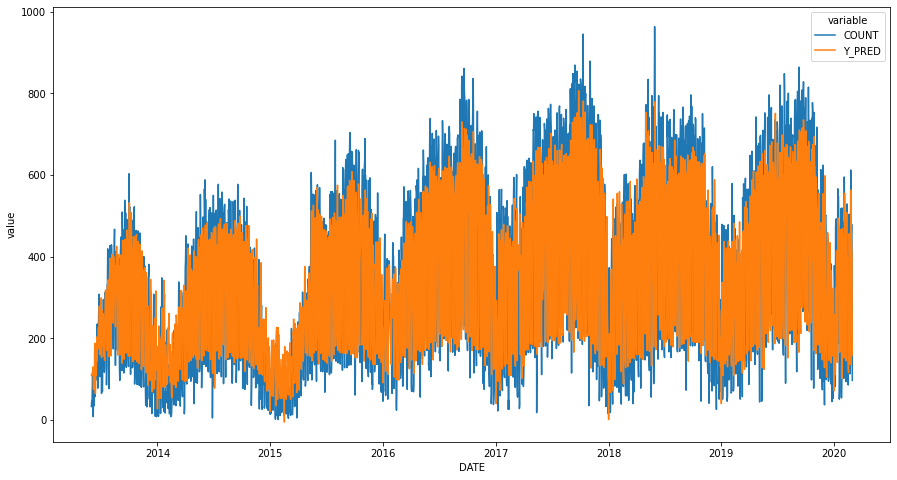

In [22]:
plot(df, 'DATE', 'COUNT', 'Y_PRED')

#### Enhancing Model Accuracy With Weather Data

Let's see how we can make our model even better with weather data. Its likely that weather and the amount of precipitation on the day will be an important signal for our model. 
  
We might start by downloading weather data or setting up an API.  But this is a lot of work when we want to build inference pipelines later.

In [23]:
def generate_precip_df(session, start_date, end_date):
    from snowflake.snowpark import functions as F 
    import pandas as pd

    tempdf = pd.read_csv('./include/weather.csv')
    tempdf['DATE']=pd.to_datetime(tempdf['dt_iso'].str.replace(' UTC', ''), 
                                 format='%Y-%m-%d %H:%M:%S %z', 
                                 utc=True).dt.tz_convert('America/New_York').dt.date
    tempdf = tempdf.groupby('DATE', as_index=False).agg(PRECIP=('rain_1h', 'mean')).round()

    precip_df = session.create_dataframe(tempdf).filter((F.col('DATE') >= start_date) &
                                                        (F.col('DATE') <= end_date))\
                       .fillna({'PRECIP':0})
    return precip_df

####  Optionally use the [Snowflake Data Marketplace](https://www.snowflake.com/data-marketplace/?_sft_dataset-category=weather) & Data Sharing
The Snowflake marketplace would allow us to very easily access weather data and join it with the trips data.  Not only is this faster and more scalable than building from a csv file or API, it is extremely easy to setup an operational pipeline to keep it fresh.  
  
For this demo we will use the "WEATHERSOURCE_AWS_EU_FRANKFURT_WEATHERSOURCE_FROSTBITE" dataset that Weather Source has made available.  Weather Source has a large number of very powerful, weather related datasets as well as an extremely talented team of developers and data scientists to help you build. 

Go to the Snowflake UI and select "Shared Data" on the left side.  Search for WEATHERSOURCE_AWS_EU_FRANKFURT_WEATHERSOURCE_FROSTBITE, select it and click on "Get Data".

In [24]:
def generate_precip_df(session, start_date, end_date):
    precip_df = session.table('WEATHERSOURCE_AWS_EU_FRANKFURT_WEATHERSOURCE_FROSTBITE.FROSTBITE.HISTORY_DAY')\
                       .filter(F.col('POSTAL_CODE') == '10007')\
                       .select(F.col('DATE_VALID_STD').alias('DATE'), 
                               F.col('TOT_PRECIPITATION_IN').alias('PRECIP'))\
                       .filter((F.col('DATE') >= start_date) &\
                               (F.col('DATE') <= end_date))\
                       .sort('DATE', ascending=False)
    return precip_df

We add a precip feature by joining the precipitation dataframe.

In [25]:
start_date, end_date = train_snowdf.select(F.min('DATE'), F.max('DATE')).collect()[0][0:2]

precip_df = generate_precip_df(session, start_date=start_date, end_date=end_date)

train_snowdf = train_snowdf.join(precip_df, 'DATE', 'inner').sort('DATE', ascending=True)

train_snowdf.show()

---------------------------------------------------------------------------------------------------------
|"DATE"      |"STATION_ID"  |"COUNT"  |"LAG_1"  |"LAG_7"  |"LAG_30"  |"LAG_365"  |"HOLIDAY"  |"PRECIP"  |
---------------------------------------------------------------------------------------------------------
|2013-06-01  |519           |33       |33       |55       |129       |229        |0          |0.00      |
|2013-06-02  |519           |46       |33       |55       |129       |229        |0          |0.52      |
|2013-06-03  |519           |41       |46       |55       |129       |229        |0          |0.54      |
|2013-06-04  |519           |72       |41       |55       |129       |229        |0          |0.00      |
|2013-06-05  |519           |114      |72       |55       |129       |229        |0          |0.03      |
|2013-06-06  |519           |68       |114      |55       |129       |229        |0          |0.24      |
|2013-06-07  |519           |8        |68     

Again, check the date range after the join.

In [26]:
train_snowdf.select(F.min('DATE'), F.max('DATE')).show()

-------------------------------------
|"MIN(""DATE"")"  |"MAX(""DATE"")"  |
-------------------------------------
|2013-06-01       |2020-02-29       |
-------------------------------------



In [27]:
df = train_snowdf.sort('DATE', ascending=True).to_pandas()
df, model, feature_columns = train_predict(df, cat_idxs=[-2], cat_dims=[2])

Selected batch size 58 for input data size: 2088
Device used : cpu
epoch 0  | loss: 167973.81055| val_0_mse: 162762.82263|  0:00:01s
epoch 1  | loss: 133934.2283| val_0_mse: 57933.162|  0:00:02s
epoch 2  | loss: 67054.5077| val_0_mse: 47731.22912|  0:00:03s
epoch 3  | loss: 23966.16805| val_0_mse: 35913.16211|  0:00:04s
epoch 4  | loss: 17016.85623| val_0_mse: 22158.42237|  0:00:05s
epoch 5  | loss: 16509.95464| val_0_mse: 20976.17695|  0:00:06s
epoch 6  | loss: 16138.93134| val_0_mse: 19899.89295|  0:00:07s
epoch 7  | loss: 15663.62627| val_0_mse: 19629.85345|  0:00:08s
epoch 8  | loss: 15149.33507| val_0_mse: 21037.79453|  0:00:09s
epoch 9  | loss: 14759.46952| val_0_mse: 19746.42643|  0:00:10s
epoch 10 | loss: 15922.31443| val_0_mse: 18821.24248|  0:00:11s
epoch 11 | loss: 14659.07476| val_0_mse: 18038.04954|  0:00:12s
epoch 12 | loss: 15375.43418| val_0_mse: 20276.55258|  0:00:13s
epoch 13 | loss: 15226.23489| val_0_mse: 21265.90294|  0:00:15s
epoch 14 | loss: 14528.05868| val_0_ms

'Error for training dataset is: 13005.114145943742'

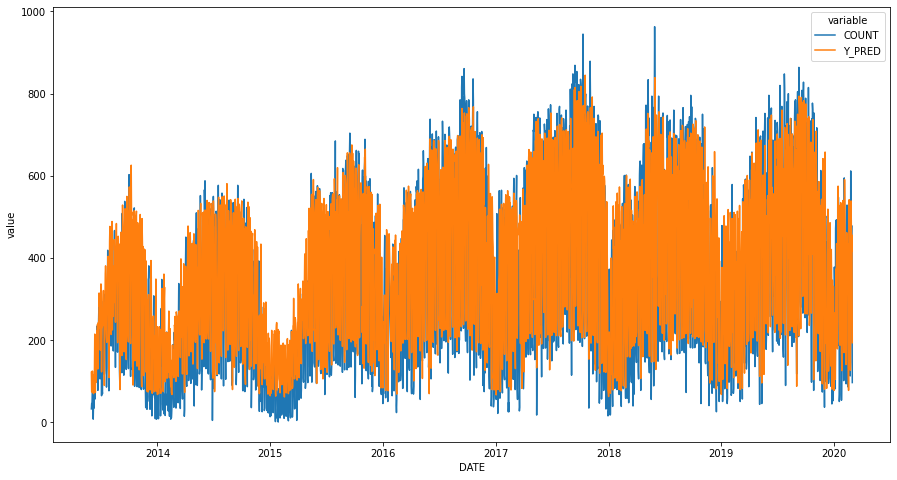

In [28]:
plot(df, 'DATE', 'COUNT', 'Y_PRED')

#### Lets look at the feature importance
One reason we chose tabnet for this analysis is the built-in abilities for explainability.

In [29]:
pd.DataFrame([model.feature_importances_], columns=feature_columns)

,LAG_1,LAG_7,LAG_30,LAG_365,HOLIDAY,PRECIP
0,0.128239,0.374788,0.060774,0.0,0.187419,0.248781


#### Lets consolidate and upate our feature functions and save them for the ML engineering team to operationalize.
Based on the feature importance above we will go with 1 and 7 day lags only.

In [40]:
%%writefile dags/feature_engineering.py

def generate_holiday_df(session, start_date, end_date):
    from snowflake.snowpark import functions as F 
    import pandas as pd
    from pandas.tseries.holiday import USFederalHolidayCalendar

    cal = USFederalHolidayCalendar()
    holiday_list = pd.DataFrame(cal.holidays(start=start_date, end=end_date), columns=['DATE'], dtype=str)
    holiday_df = session.create_dataframe(holiday_list) \
                        .toDF(holiday_list.columns[0]) \
                        .with_column("HOLIDAY", F.lit(1))
    return holiday_df

def generate_precip_df(session, start_date, end_date):
    from snowflake.snowpark import functions as F 
#    import pandas as pd
#     tempdf = pd.read_csv('./include/weather.csv')
#     tempdf['DATE']=pd.to_datetime(tempdf['dt_iso'].str.replace(' UTC', ''), 
#                                  format='%Y-%m-%d %H:%M:%S %z', 
#                                  utc=True).dt.tz_convert('America/New_York').dt.date
#     tempdf = tempdf.groupby('DATE', as_index=False).agg(PRECIP=('rain_1h', 'mean')).round()

#     precip_df = session.create_dataframe(tempdf).filter((F.col('DATE') >= start_date) &
#                                                         (F.col('DATE') <= end_date))\
#                        .fillna({'PRECIP':0})

    precip_df = session.table('WEATHERSOURCE_AWS_EU_FRANKFURT_WEATHERSOURCE_FROSTBITE.FROSTBITE.HISTORY_DAY')\
                       .filter(F.col('POSTAL_CODE') == '10007')\
                       .select(F.col('DATE_VALID_STD').alias('DATE'), 
                               F.col('TOT_PRECIPITATION_IN').alias('PRECIP'))\
                       .filter((F.col('DATE') >= start_date) &\
                               (F.col('DATE') <= end_date))\
                       .sort('DATE', ascending=False)
    return precip_df

def generate_features(session, input_df, holiday_table_name, precip_table_name):
    import snowflake.snowpark as snp
    from snowflake.snowpark import functions as F 
    
    start_date, end_date = input_df.select(F.min('STARTTIME'), F.max('STARTTIME')).collect()[0][0:2]

    holiday_df = session.table(holiday_table_name)
    try: 
        _ = holiday_df.columns()
    except:
        holiday_df = generate_holiday_df(session=session,
                                         start_date=start_date,
                                         end_date=end_date)
        
    precip_df = session.table(precip_table_name)
    try: 
        _ = precip_df.columns()
    except:
        precip_df = generate_precip_df(session=session,
                                       start_date=start_date,
                                       end_date=end_date)

    feature_df = input_df.select(F.to_date(F.col('STARTTIME')).alias('DATE'),
                                 F.col('START_STATION_ID').alias('STATION_ID'))\
                         .replace({'NULL': None}, subset=['STATION_ID'])\
                         .groupBy(F.col('STATION_ID'), F.col('DATE'))\
                         .count()

    #Impute missing values for lag columns using mean of the previous period.
    mean_1 = round(feature_df.sort('DATE').limit(1).select(F.mean('COUNT')).collect()[0][0])
    mean_7 = round(feature_df.sort('DATE').limit(7).select(F.mean('COUNT')).collect()[0][0])
    mean_365 = round(feature_df.sort('DATE').limit(365).select(F.mean('COUNT')).collect()[0][0])

    date_win = snp.Window.orderBy('DATE')

    feature_df = feature_df.with_column('LAG_1', F.lag('COUNT', offset=1, default_value=mean_1) \
                                         .over(date_win)) \
                           .with_column('LAG_7', F.lag('COUNT', offset=7, default_value=mean_7) \
                                         .over(date_win)) \
                           .with_column('LAG_365', F.lag('COUNT', offset=365, default_value=mean_365) \
                                         .over(date_win)) \
                           .join(holiday_df, 'DATE', join_type='left').na.fill({'HOLIDAY':0}) \
                           .join(precip_df, 'DATE', 'inner') \
                          .na.drop() 

    return feature_df

Overwriting dags/feature_engineering.py


Make one final test of feature engineering with our new code then train the final model.

In [41]:
#from dags.feature_engineering import generate_features

state_dict.update({'holiday_table_name': 'HOLIDAYS'})
state_dict.update({'precip_table_name' : 'WEATHER'})

snowdf = session.table(trips_table_name).filter(F.col('START_STATION_ID') == top_stations[0])

train_snowdf = generate_features(session=session, 
                                 input_df=snowdf, 
                                 holiday_table_name=state_dict['holiday_table_name'], 
                                 precip_table_name=state_dict['precip_table_name'])

df = train_snowdf.sort('DATE', ascending=True).toPandas()
df, model, feature_columns = train_predict(df, cat_idxs=[-2], cat_dims=[2])

Selected batch size 14 for input data size: 2087
Device used : cpu
epoch 0  | loss: 104212.4943| val_0_mse: 22780.83933|  0:00:03s
epoch 1  | loss: 23920.86368| val_0_mse: 21389.36545|  0:00:06s
epoch 2  | loss: 21302.66789| val_0_mse: 21048.22562|  0:00:09s
epoch 3  | loss: 19995.32336| val_0_mse: 24943.06887|  0:00:13s
epoch 4  | loss: 20405.81592| val_0_mse: 27515.96406|  0:00:16s
epoch 5  | loss: 20542.76599| val_0_mse: 21557.06053|  0:00:19s
epoch 6  | loss: 19524.76851| val_0_mse: 20377.06269|  0:00:23s
epoch 7  | loss: 20805.49744| val_0_mse: 22768.90087|  0:00:26s
epoch 8  | loss: 19365.43766| val_0_mse: 26345.68389|  0:00:29s
epoch 9  | loss: 19257.84139| val_0_mse: 21203.70913|  0:00:33s
epoch 10 | loss: 19444.07739| val_0_mse: 21544.37811|  0:00:36s
epoch 11 | loss: 19232.07381| val_0_mse: 21232.36253|  0:00:39s
epoch 12 | loss: 18895.99526| val_0_mse: 22628.42354|  0:00:43s
epoch 13 | loss: 18871.93809| val_0_mse: 23285.91575|  0:00:46s
epoch 14 | loss: 18581.38445| val_0_m

'Error for training dataset is: 15873.581566068515'

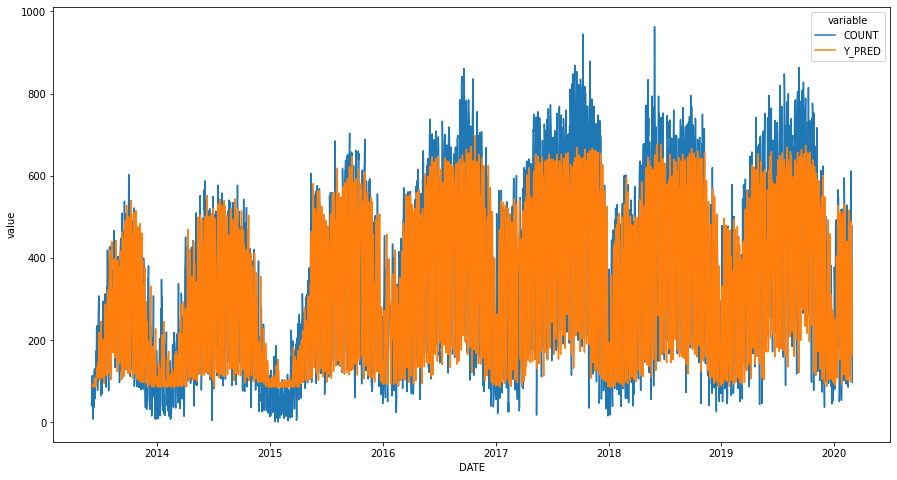

In [42]:
plot(df, 'DATE', 'COUNT', 'Y_PRED')

In [43]:
pd.DataFrame([model.feature_importances_], columns=feature_columns)

,LAG_1,LAG_7,LAG_365,HOLIDAY,PRECIP
0,0.273597,0.465177,0.0,0.050772,0.210454


### Inference Testing and Evaluation
We will want to be able to look back over an period of time to check model performance over a specific period.

In [ ]:
# def generate_past_df(session, trips_table_name, station_id, pred_period, holiday_table_name, precip_table_name):
#     from dags.feature_engineering import generate_features
    
#     end_date = session.table(trips_table_name).select(F.max('STARTTIME')).collect()[0][0]
#     pastdf = session.table(trips_table_name)\
#                     .filter(F.col('START_STATION_ID') == station_id)\
#                     .filter(F.to_date('STARTTIME') >= F.dateadd('DAY', 
#                                                                 F.lit(-7+pred_period), 
#                                                                 F.lit(end_date)))
#     newdf = generate_features(session=session, 
#                               input_df=pastdf, 
#                               holiday_table_name=holiday_table_name,
#                               precip_table_name=precip_table_name)

#     newdf = newdf.filter(F.to_date('DATE') >= F.dateadd(pred_interval,
#                                                         F.lit(pred_period),
#                                                         F.lit(end_date)))
  
#     return newdf

Lets see how our model performed for the previous 90 days

In [ ]:
pred_period=7
pred_interval='DAY'
# past_df = generate_past_df(session=session, 
#                            trips_table_name=trips_table_name, 
#                            station_id=top_stations[0], 
#                            pred_period=pred_period, 
#                            holiday_table_name=holiday_table_name,
#                            precip_table_name=precip_table_name)

# target = ['COUNT']

# df = past_df.sort('DATE', ascending=True).toPandas()

# df['Y_PRED'] = predict(model, df[feature_columns].astype(float).values).astype('int')

# MSE = mean_squared_error(y_pred=df['Y_PRED'], y_true=df[target])
# display("Error for "+str(prediction_period)+" days from "+today+" is: "+str(MSE))

In [ ]:
from datetime import timedelta
pred_period=7

station_id = str(df[-1:]['STATION_ID'].values[0])
lag_1 = int(df[-1:]['COUNT'].values)
lag_7 = int(df[-pred_period:]['COUNT'][:1].values)
count = pred = round(model.predict(nd.array([[lag_1, lag_7]]))[0][0])
future_date = df[-1:]['DATE'] + timedelta(days=1)
future_date = future_date.values[0]
forecast_data = [[station_id, future_date, count, lag_1, lag_7, pred]]

forecast_data    

In [ ]:
past_df.select(F.min('DATE'), F.max('DATE')).show()

In [ ]:
plot(df, 'DATE', 'COUNT', 'Y_PRED')

In [ ]:
import json
with open('./include/state.json', 'w') as sdf:
    json.dump(state_dict, sdf)

In [44]:
df

,DATE,STATION_ID,COUNT,LAG_1,LAG_7,LAG_365,HOLIDAY,PRECIP,Y_PRED,EXPL_LAG_1,EXPL_LAG_7,EXPL_LAG_365,EXPL_HOLIDAY,EXPL_PRECIP
0,2013-06-02,519,46,33,55,229,0,0.52,90,7.49,17.27,0.0,0.00,0.00
1,2013-06-03,519,41,46,55,229,0,0.54,90,7.49,17.27,0.0,0.00,0.00
2,2013-06-04,519,72,41,55,229,0,0.00,90,7.49,17.27,0.0,0.00,0.00
3,2013-06-05,519,114,72,55,229,0,0.03,90,7.52,17.28,0.0,0.00,0.00
4,2013-06-06,519,68,114,55,229,0,0.24,91,7.76,17.30,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,2020-02-25,519,372,612,459,441,0,0.14,486,32.88,53.68,0.0,2.56,37.50
2448,2020-02-26,519,453,372,504,323,0,0.01,489,23.94,56.55,0.0,0.00,47.58
2449,2020-02-27,519,479,453,413,341,0,0.23,392,24.53,50.65,0.0,6.61,19.97
2450,2020-02-28,519,425,479,349,388,0,0.00,382,29.60,51.03,0.0,0.00,18.50
